# Recent matches

Compute stats about the starting items and the winrates from recent matches played with the hero `HERO_NAME`.

We use the OpenDota API https://docs.opendota.com/.

In [1]:
import requests
from pprint import pprint as pp
import pandas as pd

HERO_NAME = "Ogre Magi"
SLICE_SIZE = 50

First we import some packages and define some values:

+ `HERO_NAME` is the full name of the hero.
+ `SLICE_SIZE` is a cap on how many matches are used to compute the data.
**This is mainly for debugging purposes and should be removed later on!**
 
## Get ID for `HERO_NAME`

Each hero has an ID.
This ID is referenced in the match data so we need to get it first.


In [2]:
# get a list with all heroes
req = requests.get(f"https://api.opendota.com/api/heroes")

# create a DataFrame
df_heroes = pd.DataFrame(req.json())

# filter out the hero ID for `HERO_NAME`
hero_id = df_heroes[df_heroes["localized_name"].str.contains(HERO_NAME, case=False)].iloc[0]["id"]

print(f"ID for {HERO_NAME} is {hero_id}")

ID for Ogre Magi is 84


The ID is saved as `hero_id`.

## Get recent matches for `HERO_NAME`

We can use `hero_id` to request recent games with `HERO_NAME`:
<https://docs.opendota.com/#tag/heroes%2Fpaths%2F~1heroes~1%7Bhero_id%7D~1matches%2Fget>

To get data for any of those matches we need the match ID:
<https://docs.opendota.com/#tag/matches>

**For now the match list is capped at `SLICE_SIZE` entries.**

In [3]:
# get recent hero matches
hero_matches = requests.get(f"https://api.opendota.com/api/heroes/{hero_id}/matches").json()

# extract all match IDs
matches_list = [e["match_id"] for e in hero_matches]

# request data for every match
# cap the list at 10 entries for debuggig only
match_data_list = [requests.get(f"https://api.opendota.com/api/matches/{match_id}").json() for match_id in matches_list[:SLICE_SIZE]]

## Find `HERO_NAME` players

Find the `HERO_NAME` players in all matches.

In [4]:
# list with HERO_NAME player data from all matches
hero_player = [p for m in match_data_list for p in m["players"] if p["hero_id"] == hero_id]

# TODO filter by game mode
from collections import Counter
gamemode_list = [m["game_mode"] for m in match_data_list]
cnt = Counter(gamemode_list)
pp(cnt)
pp(len(set(gamemode_list)))

Counter({2: 50})
1


## Get starting items

Now we have a list (`hero_player`) with player.
This data only for the   

First get the purchase log for each player.
Than filter buy items bought before time 0.

This starting items lists are stored in `starting_item_sets` together with a flag if the game was a win.

Games with an empty `purchase_log` are filtered out.

In [5]:
starting_item_sets = [
    # create a tuple with (<start itmes list>, <win>)
    (
        [
            i["key"] 
            for i in p["purchase_log"] 
            if i["time"]<0
        ],
        p["win"]
    ) 
    for p in hero_player
    # make sure the data is available
    if p["purchase_log"]
]

# TODO: might need a fix later on because 2xtango != 1xtango
starting_sets_list = list({tuple(set(l)) for l, _ in starting_item_sets})
foo = [(tuple(set(l)), win) for l, win in starting_item_sets]
pp(len(foo))

# get all starting items
starting_items = [i for pl, _ in starting_item_sets for i in pl]
# remove duplicates
starting_items = list(set(starting_items))

48


## Get values

Define a function (`compute_data(l, data)`) which returns a tuple of dicts (`(num_matches, num_wins)`).

Both dicts contain an entry for each item in the list `l`.
`num_matches` has the number of matches played in `data` for each item in `l`.
`num_wins` has the number of wins in `data` for each item in `l`.

In [19]:
def compute_data(l, data):
    num_matches = dict.fromkeys(l, 0)
    num_wins = dict.fromkeys(l, 0)

    for i in l:
        for item_list, win in data:
            if (i in item_list):
                num_matches[i] += 1
                if win:
                    num_wins[i] += 1
    
    return (num_matches, num_wins)

Get values (number of games played `num_matches`, number of wins `num_wins`) per item.
And put them in the DataFrame `df`.

In [34]:
num_matches, num_wins = compute_data(starting_items, starting_item_sets)

# compute the total number of matches
total_num_matches = len(starting_item_sets)

# create DataFrame from the dicts
df = pd.DataFrame(
    {
        "num_matches": num_matches,
        "wins": num_wins,
    },
    index=starting_items,
)

### Compute the winrate

Compute the winrate per item.

In [41]:
# compute winrate per item
df["winrate"] = df["wins"]/df["num_matches"]

### Compute the pickrate

Compute the pickrate per item.

In [42]:
df["pickrate"] = df["num_matches"]/total_num_matches

### Sort data

Sort the data by `SORT_COLUMN`.


In [54]:
SORT_COLUMN = "winrate"

df.sort_values(SORT_COLUMN, inplace=True)

### Plot the data

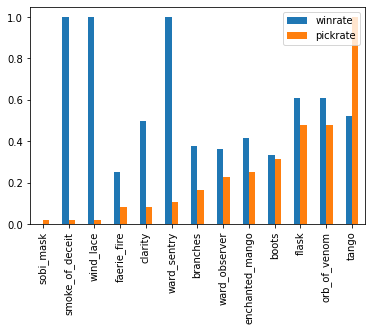

In [44]:
# plot
df[["winrate", "pickrate"]].plot.bar(secondary_y="num_matches")

### Compute a score

The score for an item is computed by multipling it's winrate with it's pickrate.

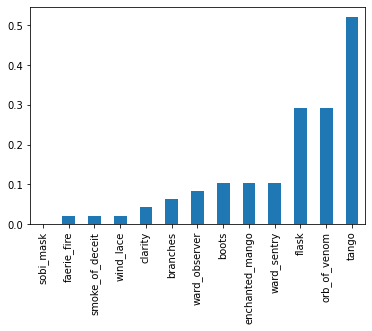

In [52]:
df["score"] = df["winrate"]*df["pickrate"]

df.sort_values("score", inplace=True)

df["score"].plot.bar()

In [53]:
pp(df.nlargest(10, columns="score"))

num_matches  wins   winrate  pickrate     score
tango                     48    25  0.520833  1.000000  0.520833
flask                     23    14  0.608696  0.479167  0.291667
orb_of_venom              23    14  0.608696  0.479167  0.291667
enchanted_mango           12     5  0.416667  0.250000  0.104167
ward_sentry                5     5  1.000000  0.104167  0.104167
boots                     15     5  0.333333  0.312500  0.104167
ward_observer             11     4  0.363636  0.229167  0.083333
branches                   8     3  0.375000  0.166667  0.062500
clarity                    4     2  0.500000  0.083333  0.041667
faerie_fire                4     1  0.250000  0.083333  0.020833
